# Fisher Code for Early Science MeerKLASS

## Constrains on auto power spectrum

### Colaboration between José Fonseca and Alkistis Pourtsidou.

In [1]:
#initialise and import CAMB

#plots
from matplotlib import pyplot as plt
%matplotlib inline

#run system 
#import sys, platform, os

#arrays and scientific
import numpy as np
pi=np.pi
#from scipy import integrate
#from scipy import linalg
import scipy
from scipy.interpolate import splrep, splev
#from scipy.interpolate import interp1d #, interp2d
from scipy.integrate import quad

#CAMB
import camb
from camb import model, initialpower

In [2]:
# General plotting things
font = {'size'   : 16, 'family':'STIXGeneral'}
axislabelfontsize='x-large'
plt.rc('font', **font)
plt.rcParams['legend.fontsize']='medium'

# Fiducial Cosmology and Power Spectrum

In [3]:
#Fiducial cosmological parameters
#Change as you please
c=2.998e5 # in Km/s
hubble=0.6774
omegab=0.05
omegac=0.26
om0=omegac+omegab
H00=100*hubble
Ass=2.14e-9
nss = 0.968

In [4]:
#Set up the fiducial cosmology
pars = camb.CAMBparams()
#Set cosmology
pars.set_cosmology(H0=H00, ombh2=omegab*pow(hubble,2), omch2=omegac*pow(hubble,2),omk=0,mnu=0)
pars.set_dark_energy() #LCDM (default)
pars.InitPower.set_params(ns=nss, r=0, As=Ass)
pars.set_for_lmax(2500, lens_potential_accuracy=0)
#calculate results for these parameters
results = camb.get_results(pars)

In [5]:
#Clean bands
bands_z=np.array([[0.25,0.35],[0.45,0.55],[1.0,1.1],[2.95,3.05],[4.95,5.05],[9.55,10.05],[24.95,25.05],[39,40]]) #[8.,9.],[30.,31.],[45.,46.]
zc=(bands_z[:,1]+bands_z[:,0])/2
Delta_z=bands_z[:,1]-bands_z[:,0]
print(zc)
print(Delta_z)

[ 0.3   0.5   1.05  3.    5.    9.8  25.   39.5 ]
[0.1 0.1 0.1 0.1 0.1 0.5 0.1 1. ]


In [6]:
#Get matter power spectrum at z: P(k,z)

def get_pk(z_in):
    #Not non-linear corrections couples to smaller scales than you want
    pars.set_matter_power(redshifts=[z_in], kmax=2.0)
    #Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 200)
    
    s8 = results.get_sigma8()
    f = results.get_fsigma8()/s8
    
    return kh, pk, f[0], s8[0]

def Pk_noh(zc,kk):
    """Returns Pk, its derivative and 
    f and sigma8"""
    kh, pk, f, s8 = get_pk(zc)
    Pkz=splrep(kh*hubble, pk[0]/pow(hubble,3))
    return splev(kk,Pkz),splev(kk,Pkz,der=1), f, s8

def get_s8_z0():
    #Not non-linear corrections couples to smaller scales than you want
    pars.set_matter_power(redshifts=[0], kmax=2.0)
    #Linear spectra
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=2.0, npoints = 200)
    
    return results.get_sigma8()[0]

s8_z0=get_s8_z0()

In [7]:
#HI parameters

#fiducial bHI fit, SKA Red Book
def bHI(zc):
    return 0.67+0.18*zc+0.05*pow(zc,2)

#fiducial OmHI, SKA Red Book
def OmHI(zc):
    return 0.00048+0.00039*zc-0.000065*pow(zc,2)

#mean brightness temperature [mK], SKA Red Book
def Tb(zc):
    return 0.0559+0.2324*zc-0.024*pow(zc,2)

#Construct P_HI(k,z) [mK^2]
def PHI(T,b,f,mu,Pk):
    return T**2*(b + f*mu**2)**2*Pk


In [8]:
# Volumes

c=2.998e5 # in Km/s
def H(z,H_0=67.74,oL=0.69,oM=0.31):
    """
    H(z) in units of km/s/Mpc
    Default cosmology
    H_0=67.74,oL=0.69,oM=0.31
    Change accordingly
    """
    return H_0*np.sqrt(oL +oM*(1+z)**3)

def chi(z,H_0=67.74,oL=0.69,oM=0.31,zi=0):
    """
    comoving distance in Mpc assuming flat universe
    Fiducials: h=0.6774; O_m=0.31
    works for an array or a single value
    initial redshift taken as zi=0, change if needed
    """
    if type(z)==float or type(z)==int:
        return quad(lambda x: c/H(x,H_0,oL,oM),zi,z)[0]
    elif type(z)==np.ndarray:
        temp=[]
        for i in range(len(z)):
            temp.append(quad(lambda x: c/H(x,H_0,oL,oM),zi,z[i])[0])
        return np.array(temp)
    else:
        return quad(lambda x: c/H(x,H_0,oL,oM),zi,z)[0]

def d_A(z):
    """
    Physical angular diameter Distance in Mpc"""
    #luminosity distnace in Mpc
    return chi(z)/(1+z)

# Volumes
#survey (bin) volume [Mpc^3]
def dVsurdz(z):    
    return c*(chi(z))**2/H(z)
    
def Vsur(zc,Dzbin,omega):
    """
    Omega in Sr"""
    return quad(lambda x: dVsurdz(x),zc-Dzbin/2,zc+Dzbin/2)[0]*omega


#Redshift bin
#ztest = 0.3
#Dzbin = 0.3

def fc(zc):
    return 1420.4/(1+zc)


In [9]:
### telescope definitions

#MK Science Verification (SV) noise specs
Ndishes=1
Ddish=30*100 #cm
Nbeams=1

def thetab(zc):
    return 1.22*21*(1+zc)/Ddish

def omegapix(zc):
    return 1.13*pow(thetab(zc),2)


In [10]:
#nu, Tsys_eta, a_eff=np.loadtxt('../Lband_Tsys.txt',unpack=True)


In [11]:
def Tsys_mk(zc):
    T_sys_meerkat_rep=splrep(nu,Tsys_eta)
    T_sys_meerkat=splev(fc(zc),T_sys_meerkat_rep)*1e3
    return T_sys_meerkat
    
#Trcv = 25.0*1e3
#Trcv = 7.0*1e3


#sky temperature
def Tsky(zc):
    return 60*pow(300/fc(zc),2.55)*1e3 ###mK

In [12]:
nu=np.arange(30,1650,0.005) #MHz
Tsys_eta=7.+60*pow(300/nu,2.55)+2.725 #K #no atm+spill
a_eff=np.pi*(Ddish/100./2.)**2*0.85/Tsys_eta

In [13]:
print (Tsys_eta)

[2.12985284e+04 2.12894833e+04 2.12804436e+04 ... 1.05016699e+01
 1.05016639e+01 1.05016579e+01]


In [14]:
print (a_eff)

[2.82099113e-02 2.82218966e-02 2.82338849e-02 ... 5.72127673e+01
 5.72128000e+01 5.72128327e+01]


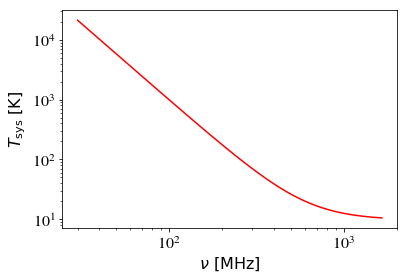

In [15]:
#comparison between analytical and MeerKAT points for Tsys
#z_test=np.arange(0,1,0.05)
plt.plot(nu, Tsys_eta,'r')
#plt.plot(fc(z_test),Trcv+Tsky(z_test),'b',label='Analytical')
plt.ylabel(r'$T_{\rm sys}\ [{\rm K}]$')
plt.xlabel(r'$\nu\ [{\rm MHz}]$')
#plt.legend()
plt.loglog()
plt.show()

In [16]:
# survey details and noise 

#Area=300.0 #deg^2
#omegatot = Area*pow(pi/180,2) #Sr
t_hour =10000
ttotal = t_hour*60*60 #20 hrs

dfpix = 50*1e3 #Hz
midfreq = 1420.4e6 #Hz

#total observation time
def tobs(zc,omegatot):
    return ttotal*(omegapix(zc)/omegatot)*Ndishes*Nbeams

#redshift resoltuion
def dzpix(zc):
    return pow(1+zc,2)*dfpix/midfreq

#sensitivity in each pixel
def sigpix(zc,Tsys,omega):
    return Tsys/np.sqrt(2*dfpix*tobs(zc,omega))

def Wsq2(kk,mu,zc):
    #add very small offset to avoid division by zero
    #alternatively one can multiply Pk by Wsq2
    return 1e-20+np.exp(-pow(kk,2)*(1-mu**2)*pow(chi(zc),2)*pow(thetab(zc),2)/(8*np.log(2)))

def Pnoise_mu(mu,kk,zc,Tsys,omega):
    return pow(sigpix(zc,Tsys,omega),2)*Vsur(zc,dzpix(zc),omegapix(zc))*pow(Wsq2(kk,mu,zc),-1.)

#angle averaged noise
def Pnoise(kk,zc,Tsys,omega):
    try:
        len(kk)
    except TypeError:
        return quad(Pnoise_mu,-1,1,args=(kk,zc,Tsys,omega))[0]
        #return quad(lambda x: Pnoise_mu(mu,kk,zc,Tsys,omega),-1,1))[0]
    else:
        raise Exception('kk should be a scalar, dummy!')    
        

        
## We will make mu=0 for now

In [17]:
#k to include
def kmax(zc):
    return 2*pi*Ddish/(chi(zc)*1.22*21*(1+zc)) #instrumental cutoff

def kmax_NL(zc):#this should be used in the Fisher Matrix for linear scales only    
    return 0.14*pow(1+zc,2/(2+nss)); #non-linear cutoff, Smith et al 2003

#k to include
def kmin(zc,Dzbin,omega):
    #return 2*pi/np.sqrt(pow(rcom(zc),2)*omegatot)
    return 2*np.pi*pow(Vsur(zc,Dzbin,omega),-1/3)
    #return 2*np.pi/chi(zc+Dzbin/2,zi=zc-Dzbin/2)


def PHIerr(zc,Dzbin,omega,kk,deltak,T,b,f,Pk,Tsys):
    return np.sqrt((2*(2*np.pi)**3/Vsur(zc,Dzbin,omega))*
                   (1/(4*np.pi*kk**2*deltak)))*(PHI(T,b,f,0,Pk)+Pnoise_mu(0,kk,zc,Tsys,omega))


In [18]:
deltak=round(kmin(0.28,0.12,100*(np.pi/180)**2),3)
print(0.28, kmin(0.28,0.12,100*(np.pi/180)**2), deltak)

0.28 0.023637629017415243 0.024


In [19]:

def plot_pk_z_bin(zc,Dzbin,area):
    #k-bin
    omega=area*(np.pi/180)**2
    
    deltak=round(kmin(zc,Dzbin,omega),3)
    
    T=Tb(zc)
    b=bHI(zc)
    
    k1 = 10**np.arange(-3,0,0.001)
    
    Pk,dPk, f, s8=Pk_noh(zc,k1)
    pk1 = PHI(T,b,f,0,Pk)
    
    #k-binned pk and error
    k1list = np.arange(kmin(zc,Dzbin,omega)+deltak/2,kmax(zc),deltak)
    Pk,dPk, f, s8=Pk_noh(zc,k1list)
    pk1list = PHI(T,b,f,0,Pk)
    pk1error = PHIerr(zc,Dzbin,omega,k1list,deltak,T,b,f,Pk,Tsys_mk(zc))
    
    #plot
    plt.figure(figsize=(8,3.5))
    plt.xscale('log')
    plt.yscale('log')
    plt.plot(k1, pk1, color='black',lw=2)
    plt.errorbar(k1list, pk1list, xerr=deltak/2,yerr=pk1error, fmt='o', color='C0',zorder=0)
    
    pk_max1=np.amax(pk1list+pk1error)
    pk_max2=np.amax(pk1)
    pk_max=max(pk_max1,pk_max2)
    plt.xlim(3e-3,0.5)
    plt.ylim(0.4*np.amin(pk1list),pk_max)
    
    plt.xlabel("$k \, \mathrm{[Mpc^{-1}]}$")
    plt.ylabel("$P_{\, \mathrm{HI}}(k) \, \mathrm{[mK^2\ Mpc^3]}$")
    
    plt.title('$z=%0.2f, \Delta z = %0.2f$' %(zc,Dzbin) +', Area='+str(area)+' deg2, time='+str(t_hour)+' hrs')
    #pl.text(1e-2,0.3*np.amin(pk1list)*1.3,'16 dishes, '+str(area)+' sq deg, 20 hrs')
    
    plt.savefig('PHI_MK_SV_'+str(area)+'deg'+str(zc)+'_20h.jpg', format="jpg", bbox_inches = 'tight')
    plt.show()
    
    

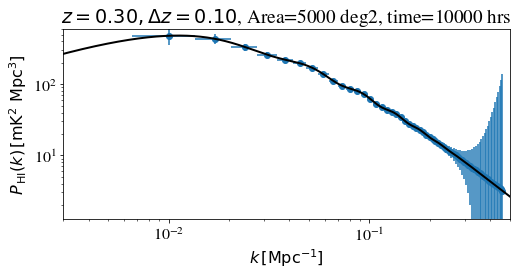

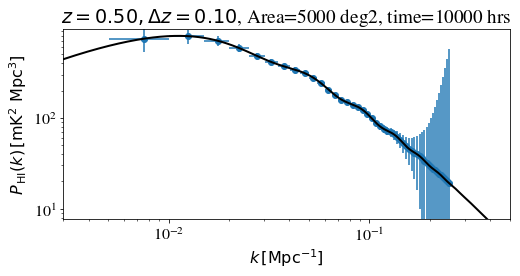

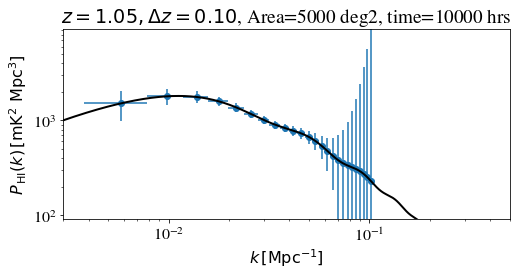

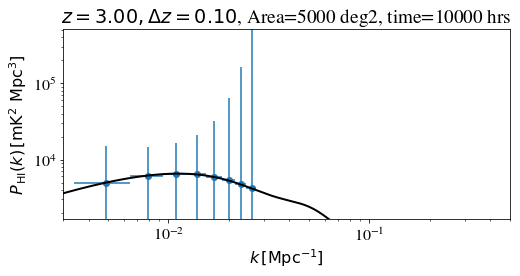

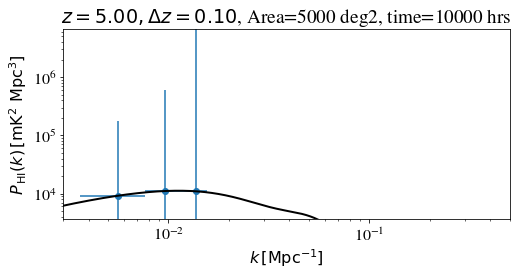

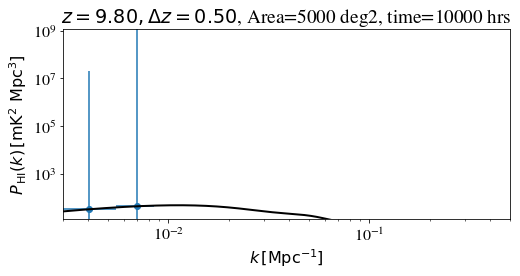

ValueError: Invalid input data

In [20]:
Area=[5000]
for j in range(len(Area)):
    for i in range(len(zc)):
        plot_pk_z_bin(zc[i],Delta_z[i],Area[j])

In [ ]:
def snr(zc,Dzbin,area):
    omega=area*(np.pi/180)**2
    #k-bin
    deltak=round(kmin(zc,Dzbin,omega),3)    
    #k-binned pk and error
    k1list = np.arange(kmin(zc,Dzbin,omega)+deltak/2,kmax(zc),deltak)
    
    Pk,dPk, f, s8=Pk_noh(zc,k1list)
    T=Tb(zc)
    b=bHI(zc)
    
    pk1list = PHI(T,b,f,0,Pk)
    pk1error = PHIerr(zc,Dzbin,omega,k1list,deltak,T,b,f,Pk,Tsys_mk(zc))
    snr_k=(pk1list/pk1error)**2
    SNR=np.sqrt(sum(snr_k))
    return SNR

In [ ]:
for j in range(len(Area)):
    for i in range(len(zc)):
        print(Area[j],':',zc[i],':',snr(zc[i],Delta_z[i],Area[j]))

## Contraints on $b_{\rm HI} \Omega_{\rm HI}$ for $\mu=0$

In [ ]:
def sig_ln_b_omega_HI(zc,Dzbin,area):
    #k-bin
    omega=area*(np.pi/180)**2
    deltak=round(kmin(zc,Dzbin,omega),3)
    
    #k-binned pk and error
    k1list = np.arange(kmin(zc,Dzbin,omega)+deltak/2,kmax(zc),deltak)
    Pk,dPk, f, s8=Pk_noh(zc,k1list)
    T=Tb(zc)
    b=bHI(zc)

    sig_bo=(4*np.pi*k1list**2*deltak)/(2*(2*np.pi)**3)*Vsur(zc,Dzbin,omega)*\
    (PHI(T,b,f,0,Pk)/(PHI(T,b,f,0,Pk)+Pnoise_mu(0,k1list,zc,Tsys_mk(zc),omega)))**2
    
    return 1/np.sqrt(np.sum(sig_bo))

for j in range(len(Area)):
    for i in range(len(zc)):
        print(Area[j],':',zc[i],':',sig_ln_b_omega_HI(zc[i],Delta_z[i],Area[j])*100)